<a href="https://colab.research.google.com/github/pn0159/prathima_INFO5731_Fall2020/blob/master/Prathima_In_Class_exercises_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In class exercise 10

The purpose of the exercise is to practice different machine learning algorithms for text clustering
Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text mysample which you want)

Apply the listed clustering methods to the dataset:

K means, 
DBSCAN,
Hierarchical clustering. 

You can refer to of the codes from  the follwing link below. 
https://www.kaggle.com/karthik3890/text-clustering 
    

In [13]:
#importing necessary libraries
import pandas as pd
from nltk.corpus import stopwords
import nltk
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('wordnet')
from sklearn.cluster import KMeans
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import metrics
import gensim
import scipy
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
#load the data
mydata=pd.read_csv("/content/sample_data/amazonreviews.csv")

In [15]:
mydata.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0


In [17]:
#Preprocessing

mydata['CleanedReviews'] = mydata['Reviews'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
mydata['CleanedReviews'] = mydata['CleanedReviews'].str.replace('[^\w\s]','')
stop = stopwords.words('english')
mydata['CleanedReviews'] = mydata['CleanedReviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
mydata['CleanedReviews'] = mydata['CleanedReviews'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(mydata['CleanedReviews'].values)

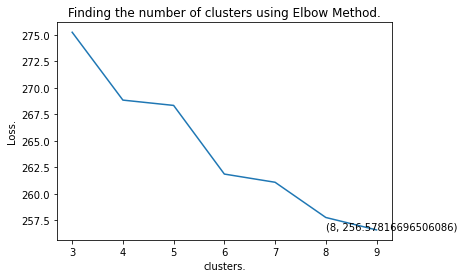

The optimal number of clusters obtained is -  8
The loss for optimal cluster is -  256.57816696506086
Silhouette Score:  0.04829282384760896
TF-IDF Cluster Labels
0    87
1    78
2    93
3    10
4    31
Name: Reviews, dtype: int64
Highest terms per cluster:
Cluster 0: excellent
 product
 love
 use
 perfect
Cluster 1: phone
 card
 would
 work
 like
Cluster 2: phone
 great
 work
 use
 love
Cluster 3: excelente
 zip
 feel
 faster
 fasti
Cluster 4: good
 phone
 quality
 choice
 easy


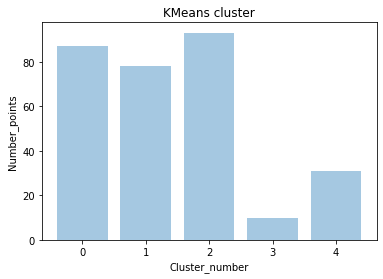

In [20]:
#Implementing Algorithms
#Using one of the methods of K-means i.e.,  Elbow Method to get the optimal number of clusters
number_of_clusters = [x for x in range(3, 10)]
squared_errors = []
for cluster in number_of_clusters:
    kmeans = KMeans(n_clusters = cluster).fit(tfidf_vectors)
    squared_errors.append(kmeans.inertia_)
optimal_clusters = np.argmin(squared_errors) + 2 
plt.plot(number_of_clusters , squared_errors)
plt.title("Finding the number of clusters using Elbow Method.")
plt.xlabel("clusters.")
plt.ylabel("Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()
print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))
optimal_k = 5
model = KMeans(n_clusters = optimal_k).fit(tfidf_vectors)
labels = model.labels_
cluster_centers = model.cluster_centers_
terms = tfidf_vectorizer.get_feature_names()
silhouette_score = metrics.silhouette_score(tfidf_vectors, labels, metric='euclidean')
print('Silhouette Score: ', silhouette_score)
mydata['TF-IDF Cluster Labels'] = labels
print(mydata.groupby(['TF-IDF Cluster Labels'])['Reviews'].count())
print("Highest terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
for i in range(optimal_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :optimal_k]:
        print(' %s' % terms[ind], end='')
        print()
plt.bar([x for x in range(optimal_k)], mydata.groupby(['TF-IDF Cluster Labels'])['Reviews'].count(), alpha = 0.4)
plt.title('KMeans cluster')
plt.xlabel("Cluster_number")
plt.ylabel("Number_points")
plt.show()     


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


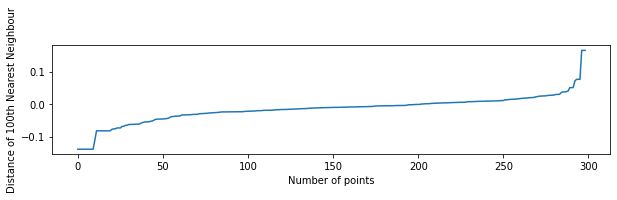

DBSCAN Cluster Labels
0    299
Name: Reviews, dtype: int64


In [25]:
#DBSCAN
list_of_reviews=[]
for review in mydata['CleanedReviews'].values:
    list_of_reviews.append(review.split())
w2v_model=gensim.models.Word2Vec(list_of_reviews, size=100, workers=4)

review_vectors = []
for review in list_of_reviews:
    review_vec = np.zeros(100)
    count_words = 0
    for word in review:
        try:
            vec = w2v_model.wv[word]
            review_vec += vec
            count_words += 1
        except:
            pass
    review_vec /= count_words
    review_vectors.append(review_vec)
    
review_vectors = np.array(review_vectors)
review_vectors = np.nan_to_num(review_vectors)
minPts = 1 * 100
def lower_bound(nums, target):
    l, r = 0, len(nums) - 1
    while l <= r: 
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l
def compute_100th_nearest_neighbour(x, data): 
    dists = []
    for val in data:
        dist = np.sum((x - val) **1 )
        if(len(dists) == 100 and dists[99] > dist): 
            l = int(lower_bound(dists, dist))
            if l < 100 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[99]

one_hundreth_neighbour = []
for val in review_vectors[:1500]:
    one_hundreth_neighbour.append(compute_100th_nearest_neighbour(val, review_vectors[:1500]) )
one_hundreth_neighbour.sort()
plt.figure(figsize=(10,2))
plt.plot([x for x in range(len(one_hundreth_neighbour))], one_hundreth_neighbour)
plt.xlabel("Number of points")
plt.ylabel("Distance of 100th Nearest Neighbour")
plt.show()
optimal_epsilon = 3
dbscan = DBSCAN(eps = optimal_epsilon, min_samples = 100).fit(review_vectors)
mydata['DBSCAN Cluster Labels'] = dbscan.labels_
print(mydata.groupby(['DBSCAN Cluster Labels'])['Reviews'].count())

Silhouette Score is:  0.4497538397569489


Hierarchical Cluster Labels
0    142
1    154
2      3
Name: Reviews, dtype: int64

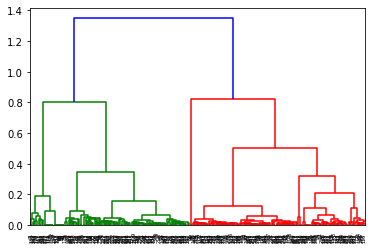

In [24]:
#Hierarchial
dendro = hierarchy.dendrogram(hierarchy.linkage(review_vectors, method='ward'))
plt.axhline(y=20)
number_of_clusters = 3
agg_model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
Agg = agg_model.fit_predict(review_vectors)
h_labels = agg_model.labels_
h_silhouette_score = metrics.silhouette_score(review_vectors, h_labels, metric='euclidean')
print('Silhouette Score is: ', h_silhouette_score)
mydata['Hierarchical Cluster Labels'] = h_labels
mydata.groupby(['Hierarchical Cluster Labels'])['Reviews'].count()

In one paragraph, please compare K means, DBSCAN and Hierarchical clustering. 

In [ ]:
"""

I have used elbow method discussed in class to find the optimal number of clusters for k-means and to find the optimal number of epsilons for DBSCAN clustering 
and dendogram for Hierarchial clustering.
From the above analysis, I can say DBSCAN to be the best performing.
and the second best is K-means Clustering because it has a higher silhouette score followed by hierarchial performing not too good for my data set"""
